### Determining binary classification of Yelp star reviews
CAPP 30254: Machine Learning for Public Policy<br>

**By:** Matt Jackson<br>
_group members:_ Aïcha Camara, Rohit Kandala, Summer Long<br>

Our project's final output will classify tweets about the Patient Protection and Affordable Care Act of 2010 ("Affordable Care Act", informally "Obamacare") as positive or negative. However, our training data -- customer reviews from Yelp.com -- uses ratings that are numeric (1 to 5 "stars"). In order to make apples-to-apples comparisons across the data sets, we need to ascertain where to create the cutoff in star ratings to produce a binary classification (or whether to do a ternary positive / neutral / negative classification, if data warrants that).

In [107]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import FreqDist

import re

tokenizer = RegexpTokenizer(r'\w+')
STOPWORDS = set(stopwords.words('english'))

In [75]:
#Set filepath to match location on your machine
reviews = pd.read_csv("yelp_oversample_20k_per_rating.csv").drop("Unnamed: 0",
                                                                 axis=1)

#Create a sub-dataset for each star rating
#TODO: Variable assignment with loop determining number/star rating
reviews_1star = reviews.loc[(reviews.loc[:,'stars'] == 1), :].copy()
reviews_2star = reviews.loc[(reviews.loc[:,'stars'] == 2), :].copy()
reviews_3star = reviews.loc[(reviews.loc[:,'stars'] == 3), :].copy()
reviews_4star = reviews.loc[(reviews.loc[:,'stars'] == 4), :].copy()
reviews_5star = reviews.loc[(reviews.loc[:,'stars'] == 5), :].copy()

star_dfs = [reviews_1star, reviews_2star, reviews_3star, reviews_4star, reviews_5star]

My recommendation is informed by two methodologies: a more subjective analysis of the most common words at each star rating, and a more automated analysis of sentiment scores at the review level using the popular VADER toolkit.

### Subjective most-common-words assessment

We find the most common unique words in each star rating, perhaps filtering down to sentiment-inflected words, to see if we can intuit an apt cutoff value between star ratings.

In [54]:

#Consulted source: 
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

def n_most(df, n):
    '''
    Get the n most common words in a dataframe of Yelp reviews.
    Excludes stopwords.

    Inputs:
        df (pandas DataFrame): set of Yelp reviews with 'text' column
        n (int): number of words you want

    Returns (nltk FreqDist): set of word-frequency tuples
    '''
    runon = ' '.join(df.loc[:,'text'])
    runon_tokens = tokenizer.tokenize(runon.lower())
    runon_destopped = out_stopwords(runon_tokens)
    return FreqDist(runon_destopped).most_common(n)

def out_stopwords(lst):
    '''
    Remove stopwords from a list of words.
    Input:
        lst (list of strings)
    Returns (lst): that string without stopwords
    '''
    return [word for word in lst if word not in STOPWORDS]

def nmost_unique_by_star(n, actually_unique=True):
    '''
    Find the words within the top n most common that are *unique* to each
    star rating.

    Inputs:
        -n (int): number for most common words (n=100 means it'll fetch the 100
        most common words from each star rating in the sample)
        
        -actually_unique (boolean): If True, return the words that occur only
        in a particular star rating and never occur in any other star rating.
        (e.g. for the 1-star reviews, return words that occur only in 1-star
        reviews, and not any other star rating.)
        If False, return all words that occur in a non-trivial subset of the
        star ratings (e.g. for the 1-star reviews, return words that occur 
        in up to four distinct star ratings, including 1-star, but not all five)
    Returns (?): some representation of most common unique words
    '''
    nmost_dict = {}
    for i, star_df in enumerate(star_dfs):
        nmost_freqs = n_most(star_df, n)
        nmost_words = [tuple[0] for tuple in nmost_freqs]
        #indices are star rating, NOT zero-based
        nmost_dict[i+1] = nmost_words

    n_in_common = set(nmost_dict[1]).intersection(set(nmost_dict[2]),
                                                          set(nmost_dict[3]),
                                                          set(nmost_dict[4]),
                                                          set(nmost_dict[5]))
    
    if actually_unique:
        top_n_unique = {}
        top_n_unique[1] = set(nmost_dict[1]) - set(nmost_dict[2]) - set(nmost_dict[3]) - set(nmost_dict[4]) - set(nmost_dict[5])
        top_n_unique[2] = set(nmost_dict[2]) - set(nmost_dict[1]) - set(nmost_dict[3]) - set(nmost_dict[4]) - set(nmost_dict[5])
        top_n_unique[3] = set(nmost_dict[3]) - set(nmost_dict[1]) - set(nmost_dict[2]) - set(nmost_dict[4]) - set(nmost_dict[5])
        top_n_unique[4] = set(nmost_dict[4]) - set(nmost_dict[1]) - set(nmost_dict[2]) - set(nmost_dict[3]) - set(nmost_dict[5])
        top_n_unique[5] = set(nmost_dict[5]) - set(nmost_dict[1]) - set(nmost_dict[2]) - set(nmost_dict[3]) - set(nmost_dict[4])

        return top_n_unique

    else:
        top_n_notallshared = {k: {word for word in v if word not in n_in_common}
                              for k,v in nmost_dict.items()}
        return top_n_notallshared



In [71]:
#Testing different settings for n to see which one comes up with a manageable set
#of words to assess.

#genuinely unique words
SETTINGS_FOR_N = [10, 50, 100, 500, 1000, 2000, 5000]

print("Truly unique words by star rating:")
for setting in SETTINGS_FOR_N:
    print(f"\nAmong top {setting}")
    nmost_string = str(nmost_unique_by_star(setting))
    print(re.sub(r' ([0-9]):', r'\n\1:', nmost_string))

#non-unique
print("\nFound at this star rating, but not all others:")
for setting in SETTINGS_FOR_N:
    print(f"\nAmong top {setting}")
    nmost_string = str(nmost_unique_by_star(setting, actually_unique=False))
    print(re.sub(r' ([0-9]):', r'\n\1:', nmost_string))

Truly unique words by star rating:

Among top 10
{1: {'never'},
2: set(),
3: set(),
4: {'really'},
5: {'go', 'best'}}

Among top 50
{1: {'car', 'give', 'still', 'called', 'left', 'manager', 'call', 'take', 'customer'},
2: set(),
3: {'ok', 'think', '3', 'though'},
4: {'night', 'area'},
5: {'amazing', 'every', 'everything', 'recommend', 'excellent', 'new'}}

Among top 100
{1: {'worst', 'waiting', 'put', 'someone', 'away', 'rude', 'business', 'pay', 'car', 'called', '30', 'horrible', 'store', 'company', 'hour', 'done', 'later', 'terrible', 'manager', 'call', 'phone', 'customer', 'money'},
2: {'disappointed', 'waitress', 'server', 'long'},
3: {'stars', 'decent'},
4: {'fried', 'hot', 'enjoyed', 'tasty', 'beer', 'fries'},
5: {'worth', 'awesome', 'loved', 'highly', 'every', 'visit', 'find', 'coffee', 'years', 'spot', 'looking', 'wonderful', 'family', 'perfect', 'clean', 'favorite', 'feel', 'super'}}

Among top 500
{1: {'returned', 'insurance', 'answer', 'treated', 'number', 'disgusting', 'web

Explore the print output above as you see fit. In general, the most useful sets of words appear to be the truly unique words from settings at  n=100 on up.

One issue with using the "truly unique" words is that, especially at 2- and 3-star ratings, there aren't very many of them. 

On the other hand, using the "not at every star rating" words results in many words in isolation that might have very different sentiment valence in-context: e.g., the positive word 'great' may appear often in 2-star reviews, but in negative phrases like "the food really wasn't great".

In general, as one might expect, sentiment words at the 3-star range appear to be intermediary ("moderate", "decent") and words that don't fit a sentiment valence especially well. It does seems as though the especially negative words are much more prevalent at 2-star and below than they are at 3-star or above.

### Notes / Directions for future analysis

If I could do this over again / had more time at this stage of exploratory analysis, here are some more leads that I might pursue:

* Create a longer and more detailed list of stopwords to eliminate things from Yelp review text that are unlikely to occur in tweets about the Affordable Care Act (e.g. the _many_ named foods, city names, common first names and surnames, occupation-specific words like "waitress"). This would get more sentiment-laden words about general customer reaction into the list of most common words, and make it easier to evaluate the data for sentiment at sight.<br><br>
* Bag-of-words sentiment analysis on the groups of most common words by star rating -- this could produce a sentiment score that allowed for deciding a cutoff in a less subjective fashion (or, at least, in a fashion that outsources the subjective judgment to a robust, peer-approved software library)<br><br>
* Plot the "n" for n most common words vs. how many words are unique to each star rating at that n (a different trendline for each star rating). It might be interesting to see if the trend is sublinear as a higher n means more common words overlap across the subsamples.

### By-review sentiment analysis

_The nltk library asks us to cite the following:_<br>
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for<br>
Sentiment Analysis of Social Media Text. Eighth International Conference on<br>
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [136]:
#Sources consulted:
#https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8

#Call nltk.download('vader_lexicon') from python interpreter before running this
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sent_analyzer = SentimentIntensityAnalyzer()

#polarity_scores() creates a dictionary object with 'neg', 'neu', 'pos', and 
# 'compound' scores in it.
#For simplicity, using only the 'compound' score

for i, star_df in enumerate(star_dfs):
    star_df.loc[:,'vader_scores'] = star_df.loc[:,'text'].apply(lambda x: 
                                                           sent_analyzer.polarity_scores(x)['compound'])



By convention, VADER scores over 0.05 are treated as 'positive', under -0.05 as 'negative', and between -0.05 and 0.05 as 'neutral.'

In [142]:
vader_stats = pd.DataFrame()

for i, star_df in enumerate(star_dfs):
    vader_stats = pd.concat((vader_stats,
              star_df.loc[:,'vader_scores'].agg(['min', 'max', 'mean', 'median', 'std'])),
              axis=1)
vader_stats.columns = [f'{i}-star' for i in range(1,6)]

vader_stats

,1-star,2-star,3-star,4-star,5-star
min,-0.998800,-0.996900,-0.993400,-0.984400,-0.980700
max,0.999000,0.999200,0.999500,0.999800,0.999600
mean,-0.200316,0.250146,0.618181,0.844875,0.880896
median,-0.433700,0.480300,0.860500,0.942300,0.949100
std,0.678222,0.670057,0.509417,0.276096,0.214964


By the looks of it, only 1-star reviews have negative mean and/or median. This suggests that it may make sense to isolate 1-star reviews as 'negative' while counting all others as 'positive'. However, each star rating has a very high standard deviation for VADER score, and all star ratings have a median quite distinct from the mean, which suggests that plotting the shape of the data may provide additional insight. Let's do that.

<AxesSubplot: >

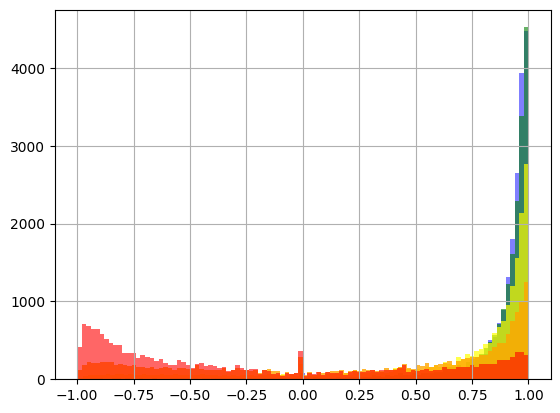

In [140]:
#fig, ax = plt.subplots(sharex=True)

#ax = reviews_1star.plot.hist(column='vader_scores', alpha=0.5, color='red')
reviews_5star['vader_scores'].hist(alpha=0.5, color='blue', bins=100)
reviews_4star['vader_scores'].hist(alpha=0.6, color='green', bins=100)
reviews_3star['vader_scores'].hist(alpha=0.7, color='yellow', bins=100)
reviews_2star['vader_scores'].hist(alpha=0.8, color='orange', bins=100)
reviews_1star['vader_scores'].hist(alpha=0.6, color='red', bins=100)





The weights seem very off here, with almost all ratings in the highly positive range. This suggests to me that maybe doing the compound polarity score separately on each star rating was skewing the results. So I tried it again, doing compound polarity score for the entire original reviews dataframe and then seeing if the distribution changed:

In [128]:
reviews.loc[:,'vader_scores'] = reviews.loc[:,'text'].apply(lambda x: 
                                                            sent_analyzer.polarity_scores(x)['compound'])

<AxesSubplot: >

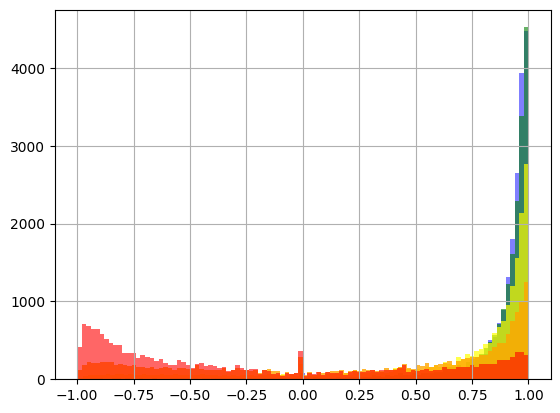

In [141]:
reviews.loc[(reviews.loc[:,'stars']==5),'vader_scores'].hist(alpha=0.5, color='blue', bins=100)
reviews.loc[(reviews.loc[:,'stars']==4),'vader_scores'].hist(alpha=0.6, color='green', bins=100)
reviews.loc[(reviews.loc[:,'stars']==3),'vader_scores'].hist(alpha=0.7, color='yellow', bins=100)
reviews.loc[(reviews.loc[:,'stars']==2),'vader_scores'].hist(alpha=0.8, color='orange', bins=100)
reviews.loc[(reviews.loc[:,'stars']==1),'vader_scores'].hist(alpha=0.6, color='red', bins=100)

It didn't.

The pattern for all ratings above 1 is a sharp left-skew (large peak on right end of distribution), whereas the pattern for 1-star reviews has a modest right-skew (small peak on left end). The peak for 2-star reviews, however, is substantially lower than the peaks for 3 to 5 stars, and both 2-star and 1-star reviews have some noticeable number of reviews along the entire gamut from -1.00 to 1.00.

### Notes / directions for future analysis

* Analyze how the VADER compound polarity scores work, to see why they're so skewed for this data set / figure out how "train" VADER so Yelp review scores aren't tilted so far towards extreme scores<br><br>
* Plot negative, positve, and neutral VADER score components on separate charts, to see if the scores underlying the compound number have their own interesting trends that don't show up in the compound score data

## Recommendation

If we were looking at things from a merely statistical standpoint using the VADER compound score, it might make sense to set the cutoff between 1-star and 1-star. However, the assessment of common words for the 2-star reviews brings up a lot of intensely negative terms, such as (to look at truly unique words in the 1000 most common) 'flavorless', 'rushed', 'raw', 'stale', 'tasteless', 'uncomfortable', and 'annoyed.' I don't want to discount that impression.

Therefore: My <u>official recommendation</u> is that, for the remainder of this project, we classify **Yelp reviews with _3 or more stars_ as "positive" $(label = 1)$**, and **all others (1 or 2 stars) as "negative" $(label=0)$**, with **no "neutral" category**. This will capture the sharp jump in positivity scores at the 3-star level and the subjective assessment that 2-star reviews have significantly more negative terms even if the naive settings for VADER didn't recognize them as such. It will also enable us to use binary classification methods, which build most directly on the course material covered thus far.

As we proceed, though, we should keep in mind that the Yelp star reviews are a rather messy, lossy measure (which makes sense, as different users don't have to follow the same standards when deciding how to review an establishment), and simplifying them to a binary classification introduces even more mess and loss. Some of our labels may strike us "incorrect" or "misleading" in ways that we can't really adjust going forward. As such, we shouldn't be surprised if it is difficult to obtain high accuracy in classification models.